In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

Загрузим датасет с жильем Бостона и применим все преобразования, которые делали в предыдущей домашней работе, которые дали максимальный результат в линейной регрессии

In [2]:
boston = load_boston()
X, y = boston.data, boston.target
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
df_boston['PRICE'] = y
df_boston = df_boston[df_boston['CRIM'] <= 9]
df_boston.loc[df_boston.ZN > 20, 'ZN'] = df_boston.ZN.median()
df_boston[df_boston.AGE < 30] = df_boston.AGE.median()
df_boston['CHAS*NOX'] = df_boston['CHAS'] * df_boston['NOX']
df_boston['CHAS^2'] = df_boston['CHAS'] ** 2
df_boston['NOX^2'] = df_boston['NOX'] ** 2
df_boston['NOX*RM'] = df_boston['NOX'] * df_boston['RM']
df_boston['NOX*DIS'] = df_boston['NOX'] * df_boston['DIS']
df_boston['NOX*PTRATIO'] = df_boston['NOX'] * df_boston['PTRATIO']
df_boston[:5]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,CHAS*NOX,CHAS^2,NOX^2,NOX*RM,NOX*DIS,NOX*PTRATIO
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,0.0,0.0,0.289444,3.537350,2.200420,8.2314
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,0.0,0.0,0.219961,3.011449,2.329570,8.3482
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,0.0,0.0,0.219961,3.369765,2.329570,8.3482
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,0.0,0.0,0.209764,3.205084,2.776488,8.5646
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,0.0,0.0,0.209764,3.273326,2.776488,8.5646


Повторим результаты линейной регрессии без полинома

In [3]:
linear_regressor_pipe = make_pipeline(StandardScaler(), LinearRegression())
X_train, X_test, y_train, y_test = train_test_split(df_boston[df_boston.columns.drop('PRICE')],
                                                    df_boston['PRICE'], test_size=0.3,
                                                    random_state=42)
linear_regressor_pipe.fit(X_train, y_train)
y_predict = linear_regressor_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
r2 = r2_score(y_test, y_predict)
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 3.4888525227678504
R2: 0.9684279485255246


Теперь попробуем предсказать цену с помощью регрессора дерева принятия решений

In [4]:
tree_regressor_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))
X_train, X_test, y_train, y_test = train_test_split(df_boston[df_boston.columns.drop('PRICE')],
                                                    df_boston['PRICE'], test_size=0.3,
                                                    random_state=42)
tree_regressor_pipe.fit(X_train, y_train)
y_predict = tree_regressor_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
r2 = r2_score(y_test, y_predict)
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 4.002641173479876
R2: 0.9584442719424826


Результат получился немного хуже, попробуем найти оптимальные параметры с помощью RandomizedSearchCV

In [5]:
tree_regressor_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor())
X_train, X_test, y_train, y_test = train_test_split(df_boston[df_boston.columns.drop('PRICE')],
                                                    df_boston['PRICE'], test_size=0.3,
                                                    random_state=42)
params = {
    'decisiontreeregressor__criterion': ["mse", "friedman_mse", "mae"],
    'decisiontreeregressor__splitter': ["best", "random"],
    'decisiontreeregressor__max_depth': np.linspace(1, 25, 14),
    'decisiontreeregressor__min_samples_split': np.linspace(0.1, 1, 20),
    'decisiontreeregressor__random_state': [42]
}
gs = GridSearchCV(estimator=tree_regressor_pipe, param_grid=params, cv=10, scoring='r2')

In [6]:
#score = cross_val_score(gs, X_train, y_train, cv=10, scoring='r2')
#print('Точность перекрестной проверки:', round(score.mean(), 5), '+-', round(score.std(), 5))

In [7]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse',
                                                              'mae'],
                         'decisiontreeregressor__max_depth': array([ 1.        ,  2.84615385,  4.69230769,  6.53846154,  8.38461538,
       10.23076923, 12.07692308, 13.92307692, 15.76923077, 17.6...
                         'decisiontreeregressor__min_samples_split': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
              

In [8]:
gs.best_params_

{'decisiontreeregressor__criterion': 'mse',
 'decisiontreeregressor__max_depth': 13.923076923076923,
 'decisiontreeregressor__min_samples_split': 0.1,
 'decisiontreeregressor__random_state': 42,
 'decisiontreeregressor__splitter': 'random'}

In [9]:
gs.best_score_

0.9354877309850386

Параметры из GridSearchCV

In [10]:
tree_regressor_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42,
                                                                        criterion='mse',
                                                                        max_depth=14,
                                                                        min_samples_split=0.1,
                                                                        splitter='random'))
tree_regressor_pipe.fit(X_train, y_train)
y_predict = tree_regressor_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
r2 = r2_score(y_test, y_predict)
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 4.289964938322814
R2: 0.9522641056002576


Ручной подбор параметров 

In [11]:
tree_regressor_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42,
                                                                        criterion='friedman_mse',
                                                                        max_depth=5,
                                                                        min_samples_split=0.2,
                                                                        splitter='best'))
tree_regressor_pipe.fit(X_train, y_train)
y_predict = tree_regressor_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
r2 = r2_score(y_test, y_predict)
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 3.3090441602063017
R2: 0.9715984066725999


В результате мы смогли улучшить модель регрессии дерева принятия решений с

    RMSE: 3.961959264318755
    R2: 0.9592847045570779

до

    RMSE: 3.309044160206302
    R2: 0.9715984066725999

При этом качество модели получилось выше, чем у нашей линейной регресии с метриками

    RMSE: 3.4888525227729703
    R2: 0.9684279485254319

In [12]:
dot_data = export_graphviz(tree_regressor_pipe._final_estimator, filled=True, rounded=True, feature_names=X_test.columns, out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

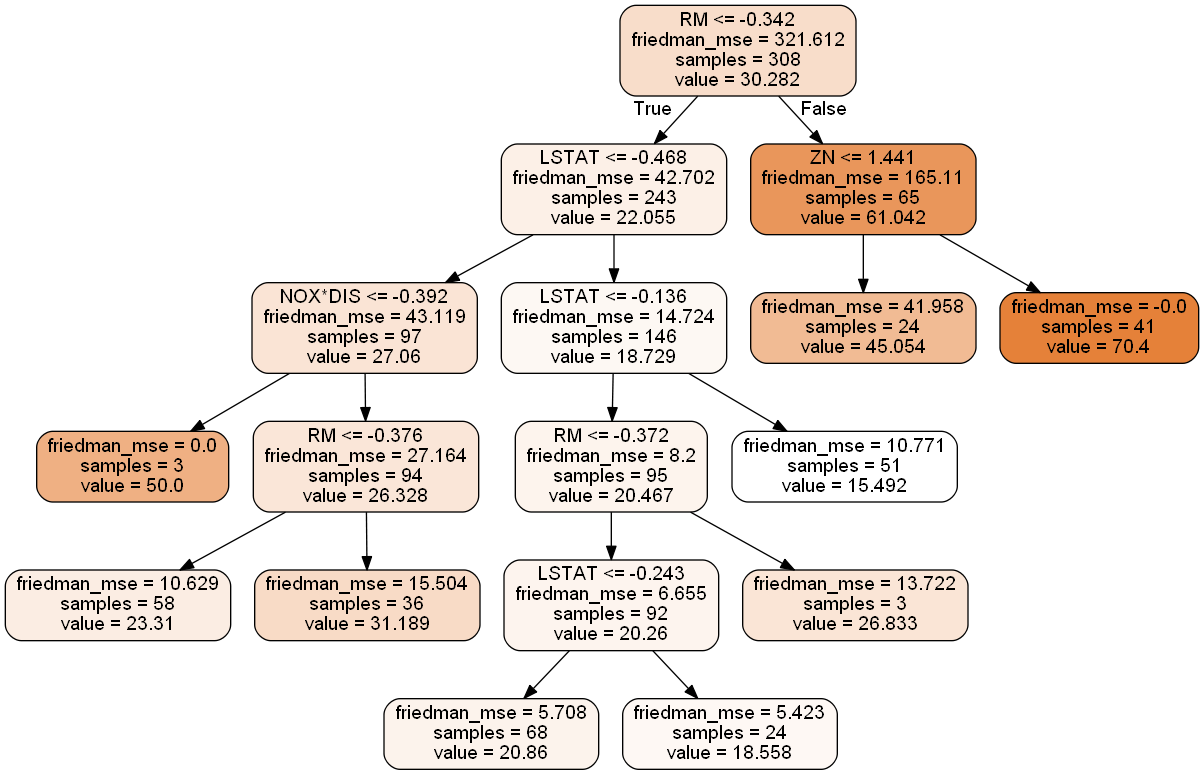

In [13]:
Image(filename='tree.png') 